In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import precision_score, recall_score, log_loss, plot_confusion_matrix, accuracy_score, f1_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

In [2]:
X_df = pd.read_csv("Training_set_values.csv")
y_df = pd.read_csv("Training_set_labels.csv")

X_submit = pd.read_csv("Test_set_values.csv")

In [3]:
train_df = pd.merge(y_df, X_df, how='inner', on='id')

In [4]:
train_df['status'] = train_df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})

In [5]:
train_df

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,2
59397,37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,2
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2


In [6]:
train_df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [7]:
train_df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [8]:
train_df = train_df.drop(['scheme_name', 
                         'num_private', 
                         'lga', 
                         'ward', 
                         'recorded_by', 
                         'extraction_type',
                         'extraction_type_class',
                         'management_group',
                         'payment',
                         'water_quality',
                         'quantity',
                         'source',
                         'source_class',
                         'waterpoint_type',
                         'date_recorded',
                         'public_meeting',
                         'scheme_management'], axis=1)
                        

In [9]:
train_df = train_df.set_index('id')

In [10]:
num_dict = {}
dfp = train_df.copy().drop(['status_group', 'status'], axis =1)

for x in dfp.columns:
    if dfp[x].dtypes == 'object':
        num_dict[x] = len(dfp[x].value_counts())
num_dict
    

{'funder': 1897,
 'installer': 2145,
 'wpt_name': 37400,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'permit': 2,
 'extraction_type_group': 13,
 'management': 12,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_type': 7,
 'waterpoint_type_group': 6}

In [11]:
train_df = train_df.drop(['funder','installer','wpt_name','subvillage'], axis=1)

In [12]:
train_df.isna().sum()

status_group                0
amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_group       0
management                  0
payment_type                0
quality_group               0
quantity_group              0
source_type                 0
waterpoint_type_group       0
status                      0
dtype: int64

In [13]:
train_df = train_df.dropna()

In [14]:
train_df.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
population               0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
status                   0
dtype: int64

In [15]:
train_df['permit'] = train_df['permit'].astype(int)

In [16]:
X = train_df.drop(['status_group', 'status'], axis=1)
y = train_df['status']

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56344 entries, 69572 to 26348
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56344 non-null  float64
 1   gps_height             56344 non-null  int64  
 2   longitude              56344 non-null  float64
 3   latitude               56344 non-null  float64
 4   basin                  56344 non-null  object 
 5   region                 56344 non-null  object 
 6   region_code            56344 non-null  int64  
 7   district_code          56344 non-null  int64  
 8   population             56344 non-null  int64  
 9   permit                 56344 non-null  int32  
 10  construction_year      56344 non-null  int64  
 11  extraction_type_group  56344 non-null  object 
 12  management             56344 non-null  object 
 13  payment_type           56344 non-null  object 
 14  quality_group          56344 non-null  object 
 15

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
X_train_ohe = X_train.select_dtypes('object')
X_train_ohe = pd.concat([X_train_ohe, X_train[['region_code', 'district_code']]], axis=1)
X_test_ohe = X_test.select_dtypes('object')
X_test_ohe = pd.concat([X_test_ohe, X_test[['region_code', 'district_code']]], axis=1)

ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
ohe.fit(X_train_ohe)
X_train_ohe_trans = ohe.transform(X_train_ohe)
X_test_ohe_trans = ohe.transform(X_test_ohe)

train_temp_df = pd.DataFrame(X_train_ohe_trans, columns=ohe.get_feature_names(), index=X_train.index)
test_temp_df = pd.DataFrame(X_test_ohe_trans, columns=ohe.get_feature_names(), index=X_test.index)

X_train_ss = X_train.select_dtypes(exclude='object').drop(['permit','region_code','district_code'], axis=1)
X_test_ss = X_test.select_dtypes(exclude='object').drop(['permit','region_code','district_code'], axis=1)

ss = StandardScaler()
ss.fit(X_train_ss)
X_train_scaled = ss.transform(X_train_ss)
X_test_scaled = ss.transform(X_test_ss)

train_temp_df1 = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train_ss.columns)
test_temp_df1 = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test_ss.columns)


train_temp_df2 = X_train[['permit']]
test_temp_df2 = X_test[['permit']]

X_train_clean = pd.concat([train_temp_df1, train_temp_df2, train_temp_df], axis=1)
X_test_clean = pd.concat([test_temp_df1, test_temp_df2, test_temp_df], axis=1)

In [20]:
X_train_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,...,x10_23,x10_30,x10_33,x10_43,x10_53,x10_60,x10_62,x10_63,x10_67,x10_80
id,,,,,,,,,,,,,,,,,,,,,
41707,-0.120902,-0.956517,-0.429995,1.327036,-0.383571,-1.376644,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58402,-0.120902,0.686173,0.532329,0.694344,-0.256163,0.732807,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64225,-0.120902,-0.956517,-0.380849,1.315108,-0.383571,-1.376644,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3263,2.073749,0.451503,0.182595,-1.420047,0.678165,0.741232,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31729,-0.102613,-0.891331,0.704166,-0.344189,-0.381447,0.741232,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_test_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,...,x10_23,x10_30,x10_33,x10_43,x10_53,x10_60,x10_62,x10_63,x10_67,x10_80
id,,,,,,,,,,,,,,,,,,,,,
18237,-0.120902,-0.469794,0.529709,-0.150373,0.041123,0.740179,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41342,-0.084324,-0.910163,0.760336,-0.411938,-0.277397,0.740179,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27591,-0.120902,-0.956517,-0.151045,-1.151295,-0.383571,-1.376644,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26533,-0.120902,1.271400,0.086188,1.303287,0.678165,0.740179,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14938,-0.120902,-0.889883,0.701419,-0.340664,-0.381447,0.740179,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
def model_score(model, X, y_predict, y_true):
    acc = accuracy_score(y_predict, y_true)
    rec = recall_score(y_predict, y_true, average='weighted')
    f1 = f1_score(y_predict, y_true, average='weighted')
    prec = precision_score(y_predict, y_true, average='weighted')
    cross = cross_val_score(estimator=model, X=X, y=y_true, cv=10).mean()
    
    print(f' The accuracy score is: {round(acc, 4)}')
    print(f' The cross validation score of accuracy is: {round(cross, 4)}')
    print(f' The recall score is: {round(rec, 4)}')
    print(f' The F1 score is: {round(f1, 4)}')
    print(f' The precision score is: {round(prec, 4)}')
    
    return plot_confusion_matrix(model, X, y_true);

0.45194782145709467


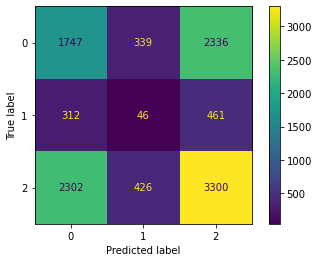

In [23]:
dummy = DummyClassifier(random_state=16)
dummy.fit(X_train_clean, y_train)
print(dummy.score(X_test_clean, y_test))

plot_confusion_matrix(dummy, X_test_clean, y_test);

Training data model score:
 The accuracy score is: 0.7424
 The cross validation score of accuracy is: 0.739
 The recall score is: 0.7424
 The F1 score is: 0.7658
 The precision score is: 0.8094


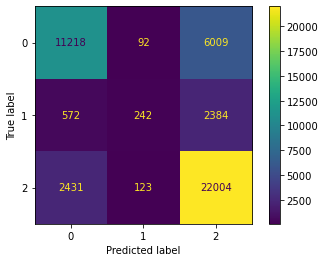

In [24]:
log_model = LogisticRegression(multi_class = "multinomial")
log_model.fit(X_train_clean, y_train)
log_y_pred_train = log_model.predict(X_train_clean)

print("Training data model score:")
log_train_score = model_score(log_model, X_train_clean, log_y_pred_train, y_train)

In [25]:
import statsmodels.api as sm

log_reg = sm.GLM(y_train, X_train_clean).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                45075
Model:                            GLM   Df Residuals:                    44961
Model Family:                Gaussian   Df Model:                          113
Link Function:               identity   Scale:                         0.58744
Method:                          IRLS   Log-Likelihood:                -51908.
Date:                Wed, 08 Dec 2021   Deviance:                       26407.
Time:                        15:13:29   Pearson chi2:                 2.64e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
amount_tsh                     0.0120      0.004      3.212      0.001       0.005       0.019
gps_height                     0.0314      0.010      3.168      0.002       0.012       0.051
longitude                     -0.0080      0.008     -1.052      0.293      -0.023       0.007
latitude                       0.0181      0.030      0.604      0.546      -0.041       0.077
population                     0.0266      0.004      6.752      0.000       0.019       0.034
construction_year             -0.0052      0.012     -0.428      0.669      -0.029       0.019
permit                         0.1352      0.010     13.180      0.000       0.115       0.155
x0_Lake Nyasa                  0.4138      0.041     10.074      0.000       0.333       0.494
x0_Lake Rukwa                 -0.0802      0.037     -2.159      0.031      -0.153      -0.007
x0_Lake Tanganyika             0.0337      0.026      1.286      0.198      -0.018       0.085
x0_Lake Victoria               0.0532      0.027      1.970      0.049       0.000       0.106
x0_Pangani                    -0.1167      0.029     -4.010      0.000      -0.174      -0.060
x0_Rufiji                      0.1469      0.034      4.305      0.000       0.080       0.214
x0_Ruvuma / Southern Coast     0.3018      0.051      5.976      0.000       0.203       0.401
x0_Wami / Ruvu                 0.0219      0.031      0.709      0.479      -0.039       0.082
x1_Dar es Salaam              -0.1727      0.110     -1.568      0.117      -0.389       0.043
x1_Dodoma                     -0.3322      0.215     -1.545      0.122      -0.753       0.089
x1_Iringa                     -0.2504      0.290     -0.864      0.387      -0.818       0.318
x1_Kagera                      0.2130      0.217      0.982      0.326      -0.212       0.638
x1_Kigoma                     -0.3972      0.108     -3.682      0.000      -0.609      -0.186
x1_Kilimanjaro                -0.2638      0.107     -2.459      0.014      -0.474      -0.054
x1_Lindi                      -0.6285      0.171     -3.686      0.000      -0.963      -0.294
x1_Manyara                    -0.2040      0.107     -1.900      0.057      -0.414       0.006
x1_Mara                       -0.5246      0.109     -4.795      0.000      -0.739      -0.310
x1_Mbeya                      -0.3352      0.110     -3.041      0.002      -0.551      -0.119
x1_Morogoro                   -0.4396      0.129     -3.410      0.001      -0.692      -0.187
x1_Mtwara                     -0.3695      0.137     -2.690      0.007      -0.639      -0.100
x1_Mwanza                     -0.2379      0.172     -1.380      0.168      -0.576       0.100
x1_Pwani                       0.0425      0.204      0.208      0.835      -0.358       0.443
x1_Rukwa                      -0.3453      

In [28]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train_clean, y_train)

#scores on folds
scores = cross_val_score(estimator=random_forest, X=X_train_clean, y=y_train, cv=5)
print(np.mean(scores))

#scores on on test
score = random_forest.score(X_test_clean, y_test)
print(score)

# grid search on random forest
grid = {
    'criterion' : ['entropy', 'gini'],
    'max_depth': [5,10,15,20, None],
    'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3,0.4, 0.5], #values selected based on gini   
    'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5], #values selected based on gini
    'bootstrap' : [False, True] 
}
gs = GridSearchCV(estimator=random_forest , param_grid=grid, cv=5)
gs.fit(X_train_clean, y_train)

print(f'Best parameters are {gs.best_params_}')
print(f'Best score {gs.best_score_}')
print(f'Best estimator score {gs.best_estimator_.score(X_test_clean, y_test)}')



# #grid search on random forest
# grid = {
#     'criterion' : ['entropy', 'gini'],
#     'max_depth': [5,10,15,20, None],
#     'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3,0.4, 0.5],
#     'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5],
#     'bootstrap' : [False, True] 
# }
# gs = GridSearchCV(estimator=dt , param_grid=grid, cv=5)
# gs.fit(X_train, y_train)

# print(f'Best parameters are {gs.best_params_}')
# print(f'Best score {gs.best_score_}')
# print(f'Best estimator score {gs.best_estimator_.score(X_test, y_test)}')





 The accuracy score is: 0.9945
 The cross validation score of accuracy is: 0.7963
 The recall score is: 0.9945
 The F1 score is: 0.9945
 The precision score is: 0.9945


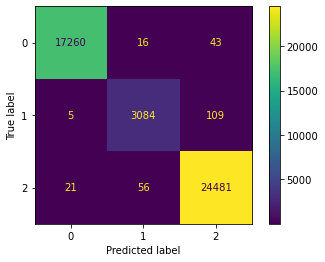

In [31]:
model_score(random_forest, X_train_clean, random_forest.predict(X_train_clean), y_train )

In [29]:
print(np.mean(scores))

0.7957626178591237


In [33]:
score = random_forest.score(X_test_clean, y_test)
score

0.7982962108439081

In [36]:


#grid search on random forest
grid = {
    'criterion' : ['entropy', 'gini'],
    'max_depth': [5,10,15,20, None],
    'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3,0.4, 0.5],
    'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5],
    'bootstrap' : [False, True] 
}
gs = GridSearchCV(estimator=random_forest , param_grid=grid, cv=5)
gs.fit(X_train_clean, y_train)

print(f'Best parameters are {gs.best_params_}')
print(f'Best score {gs.best_score_}')
print(f'Best estimator score {gs.best_estimator_.score(X_test_clean, y_test)}')

Best parameters are {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'min_impurity_decrease': 0.0, 'min_impurity_split': None}
Best score 0.8010648918469216
Best estimator score 0.8013133374744875


In [37]:
#Can use attributes in random forest to display multiple decision trees
feat_import = {name: score 
                   for name, score 
                       in zip(X_train.columns, random_forest.feature_importances_)
}
feat_import

{'amount_tsh': 0.028212037626818925,
 'gps_height': 0.0766358435115753,
 'longitude': 0.15726741578307277,
 'latitude': 0.1543743329239899,
 'basin': 0.05387579382640206,
 'region': 0.05964108017567496,
 'region_code': 0.010193120269924267,
 'district_code': 0.0031126744345025166,
 'population': 0.002412708151520895,
 'permit': 0.003546313870288151,
 'construction_year': 0.0036832310309116013,
 'extraction_type_group': 0.0031416166795072593,
 'management': 0.0035508317453014863,
 'payment_type': 0.002502210332189156,
 'quality_group': 0.0031941126471517565,
 'quantity_group': 0.0004958898482015312,
 'source_type': 0.001910583680224501,
 'waterpoint_type_group': 0.004672302950617412}

In [52]:
len(random_forest.estimators_)

100

In [85]:
random_forest2 = RandomForestClassifier(max_depth=23)
random_forest2.fit(X_train_clean, y_train)

RandomForestClassifier(max_depth=3)

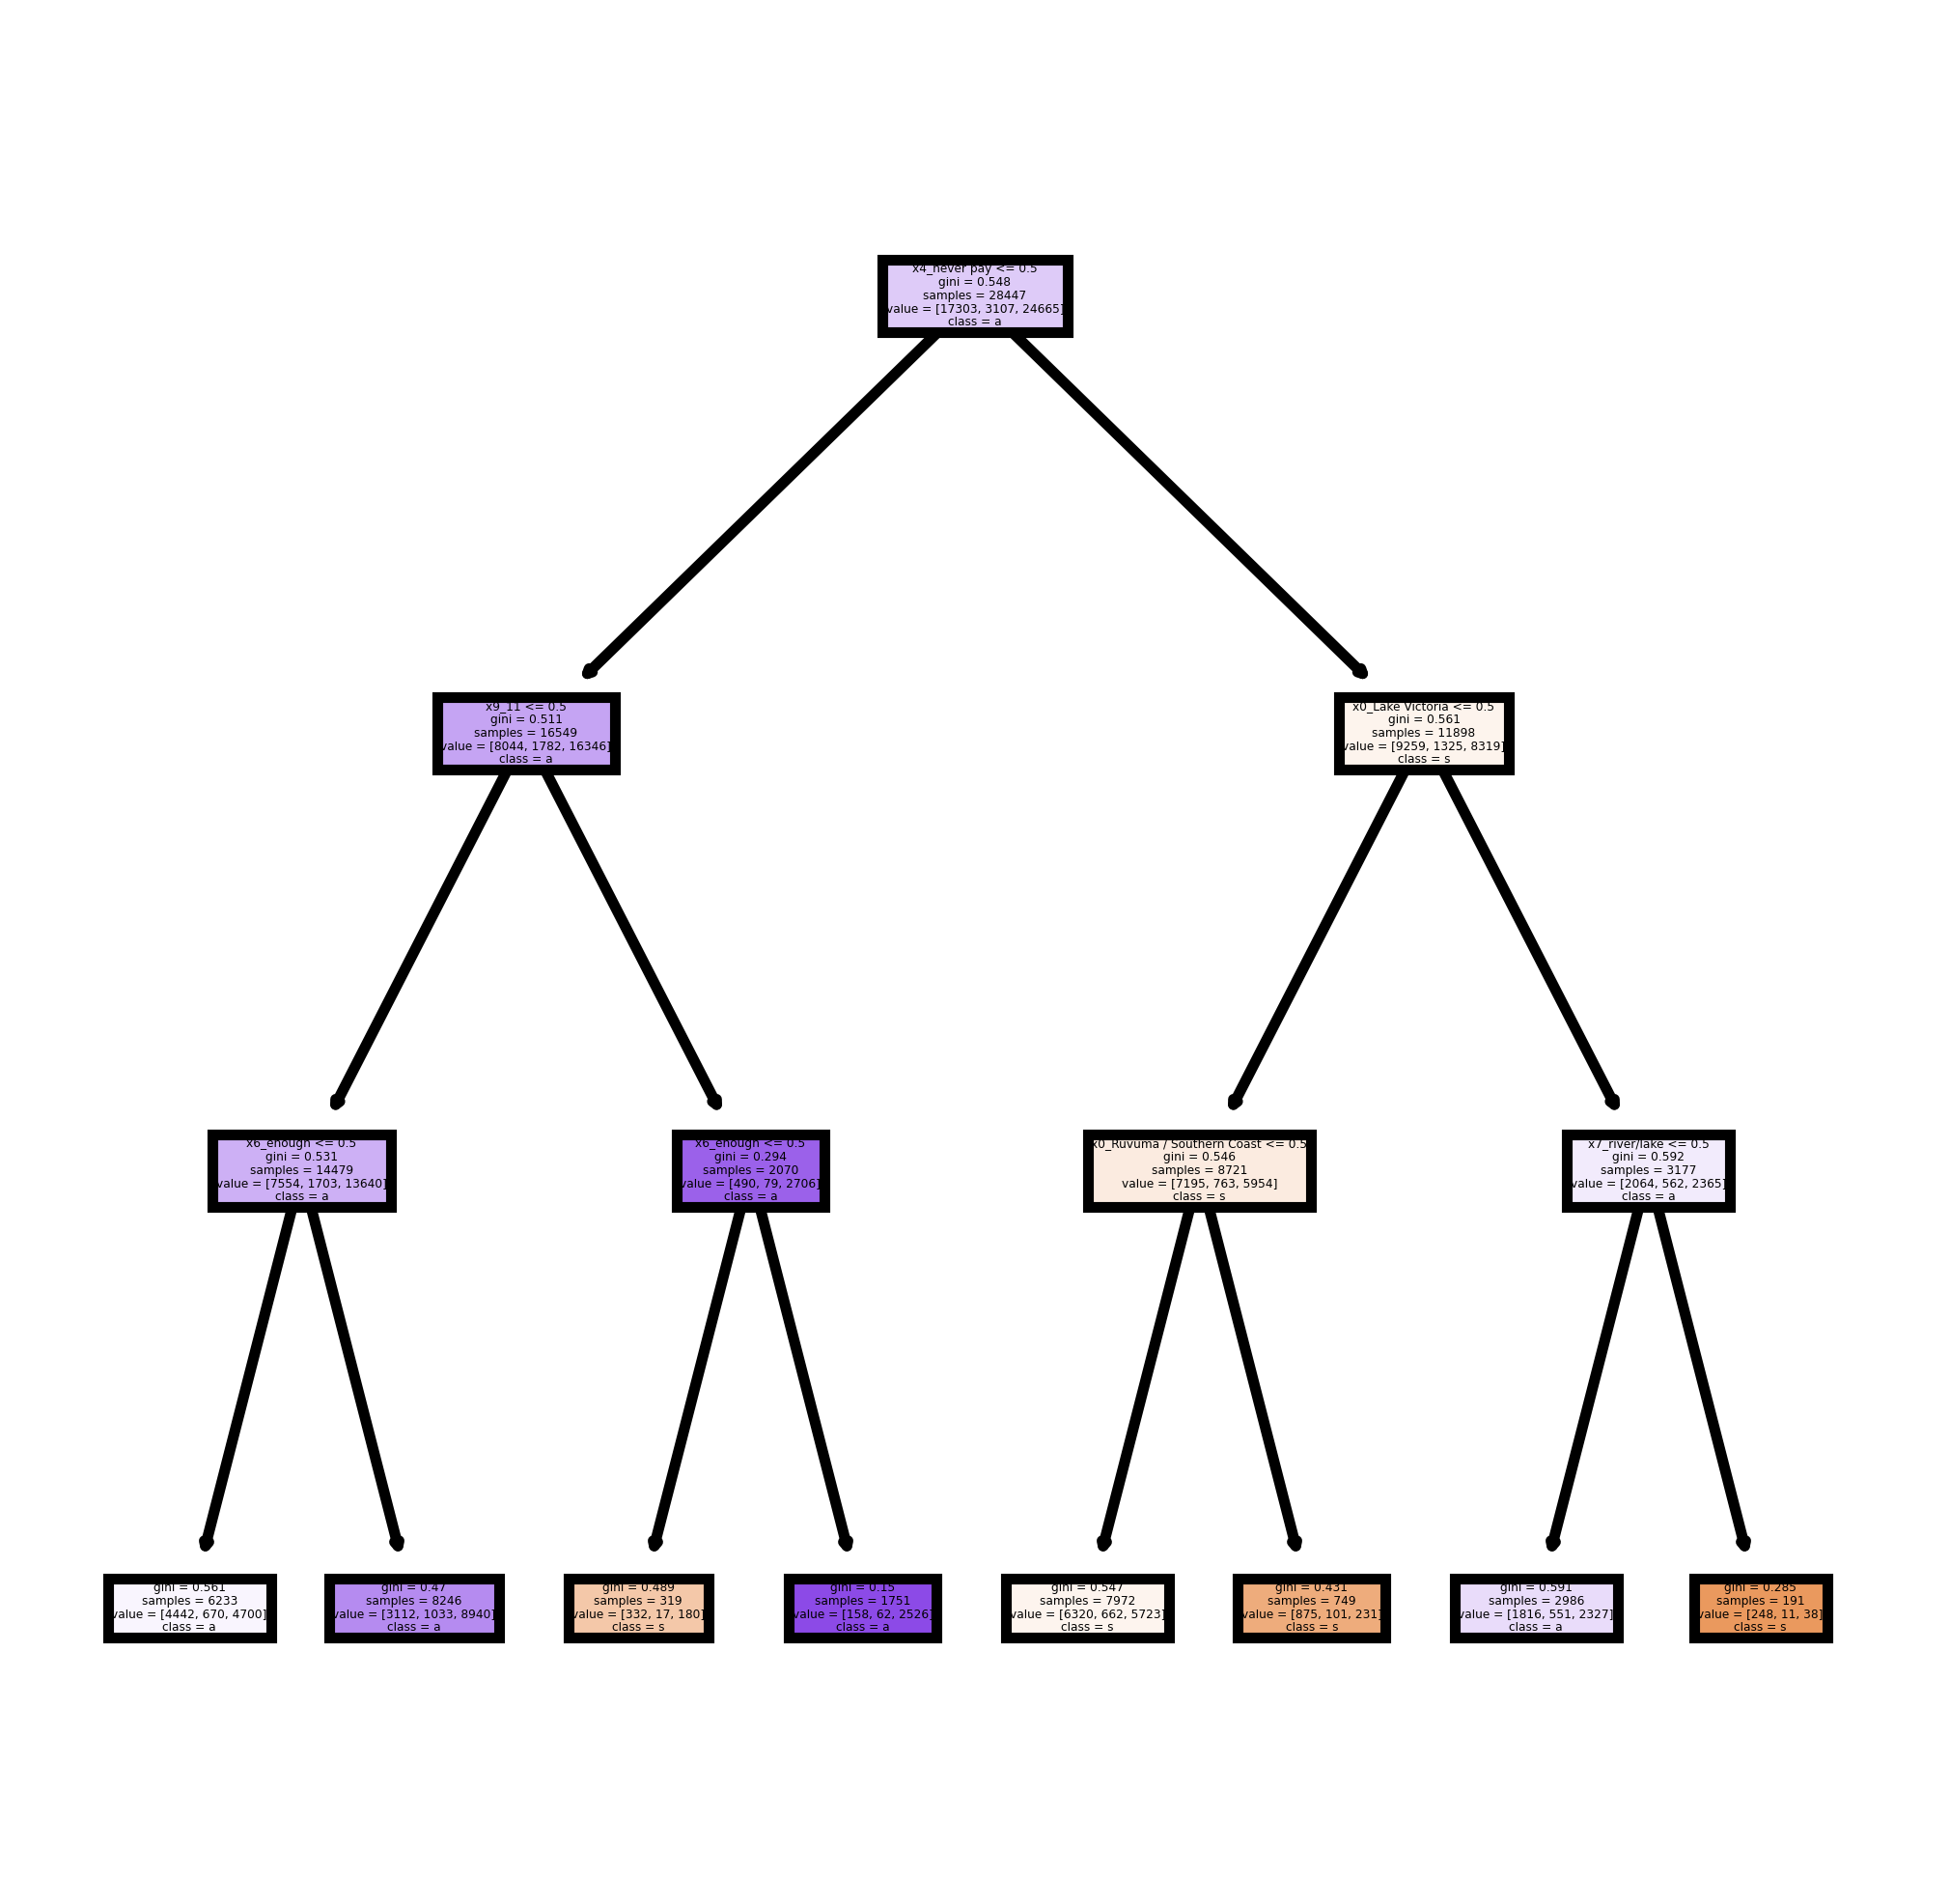

In [86]:
random_forest2 = RandomForestClassifier(max_depth=23)
random_forest2.fit(X_train_clean, y_train)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=800)
tree.plot_tree(random_forest2.estimators_[0],
               feature_names = X_train_clean.columns, 
               class_names=y_train.name,
               filled = True);


In [ ]:
model_score(random_forest2, X_train_clean, random_forest2.predict(X_train_clean), y_train )

In [54]:
from sklearn import tree
# from dtreeviz.trees import dtreeviz 
from matplotlib import pyplot as plt


In [55]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(random_forest.estimators_[0], feature_names = X_train_clean.columns, filled = True)

Error in callback <function flush_figures at 0x0000023ADECC3F70> (for post_execute):


KeyboardInterrupt: 

In [38]:
from sklearn.tree import export_graphviz
export_graphviz()

In [50]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz( random_forest[0], out_file='tree.dot', 
                feature_names = list(X_train_clean.columns.values),
#                 class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified